Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [81]:
import pathlib
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, regularizers,Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import glob

In [82]:
## Mount gdrive and read dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [83]:
# Defining the path for train and test images

dir_path = '/content/drive/Skin cancer ISIC The International Skin Imaging Collaboration'

data_dir_train = pathlib.Path(f'{dir_path}/Train')
data_dir_test = pathlib.Path(f'{dir_path}/Test')

train_files = os.listdir(data_dir_train)
test_files = os.listdir(data_dir_test)

print("Training data categories:", train_files)

Training data categories: ['seborrheic keratosis', 'basal cell carcinoma', 'actinic keratosis', 'pigmented benign keratosis', 'melanoma', 'nevus', 'dermatofibroma', 'vascular lesion', 'squamous cell carcinoma']


In [84]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

6739
118


### Load using keras.preprocessing



### Create a dataset

Define some parameters for the loader:

In [85]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [86]:
#Trainig data set
train_ds = image_dataset_from_directory(data_dir_train,
                                        validation_split=0.2,
                                        subset="training",
                                        seed=123,
                                        image_size=(img_height, img_width),
                                        batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [87]:
#Validation dataset
val_ds = image_dataset_from_directory(data_dir_train,
                                      validation_split=0.2,
                                      subset="validation",
                                      seed=123,
                                      image_size=(img_height, img_width),
                                      batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [88]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### visualize one instance of all the nine classes present in the dataset

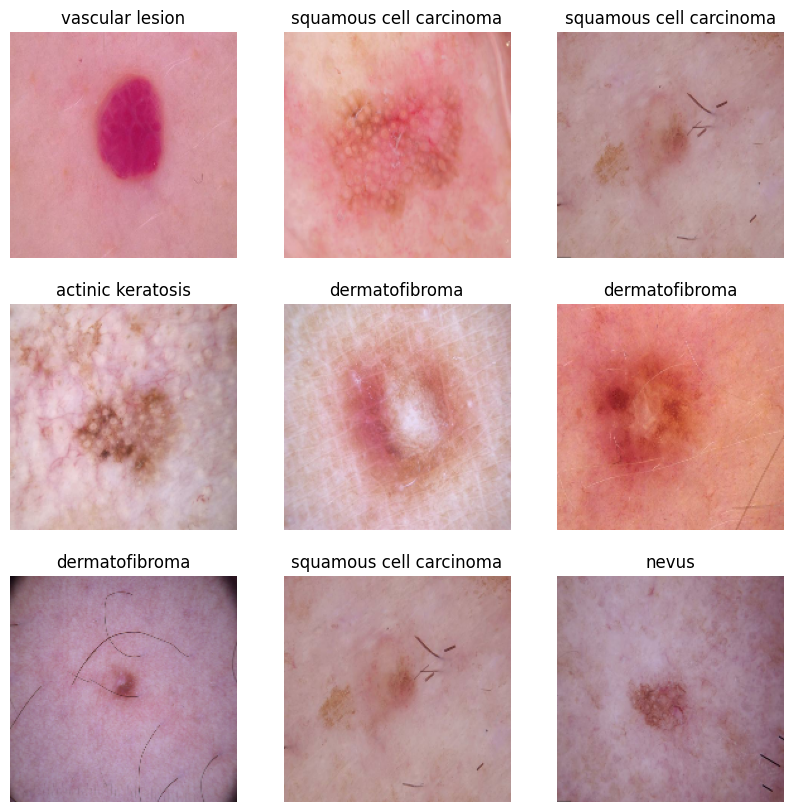

In [89]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [90]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create Model

In [91]:
# Building a CNN model from scratch
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [92]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [93]:
# View the summary of all layers
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [94]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.2703 - loss: 1.8950 - val_accuracy: 0.5113 - val_loss: 1.3165
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5248 - loss: 1.2723 - val_accuracy: 0.6021 - val_loss: 1.0495
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6601 - loss: 0.9596 - val_accuracy: 0.6822 - val_loss: 0.8893
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7642 - loss: 0.6790 - val_accuracy: 0.7726 - val_loss: 0.6662
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8441 - loss: 0.4562 - val_accuracy: 0.8229 - val_loss: 0.5948
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8803 - loss: 0.3450 - val_accuracy: 0.8144 - val_loss: 0.6047
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8931 - loss: 0.3122 - val_accuracy: 0.8999 - val_loss: 0.3357
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9250 - loss: 0.2236 - val_acc

### Visualizing training results

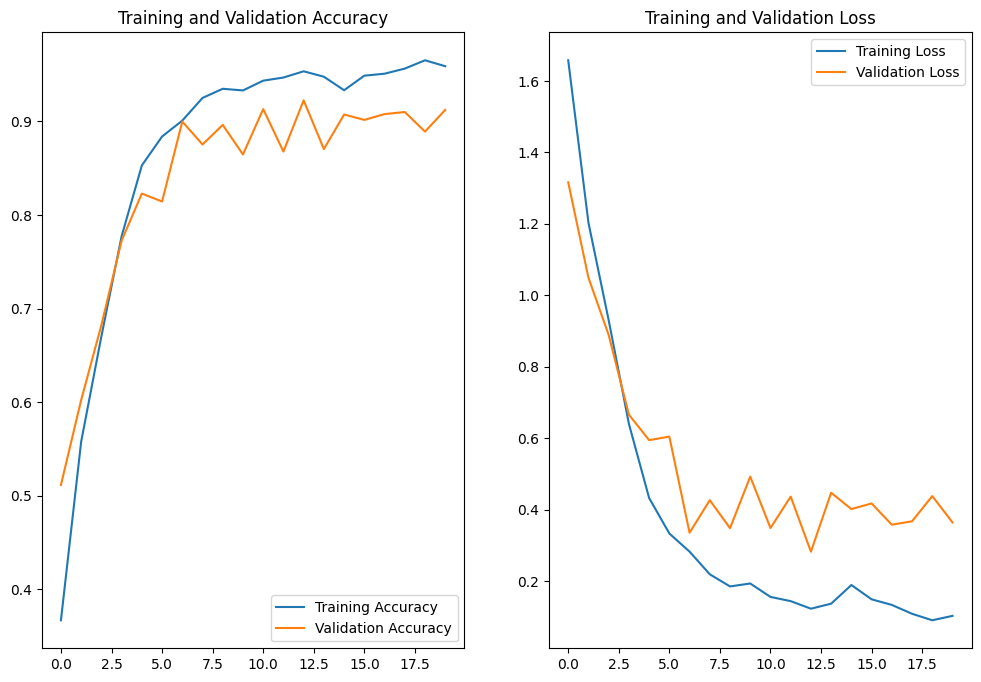

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### The graph shows that validation accuracy fluctuates and plateaus while the training accuracy continues to improve suggests that the model may be overfitting to the training data.
##### It is learning patterns from the training data that are not generalizing well to unseen validation data .  The increasing validation loss, coupled with a decreasing training loss, is a classic sign of overfitting. The model performs well on the training data (low loss) but fails to generalize to the validation data (high loss).

#### Since the above model is overfitting to the training data , augmentation strategy such as  RandomFlip, RandomRotation, Contrast and Brightness change and random zooming will be applied on the data

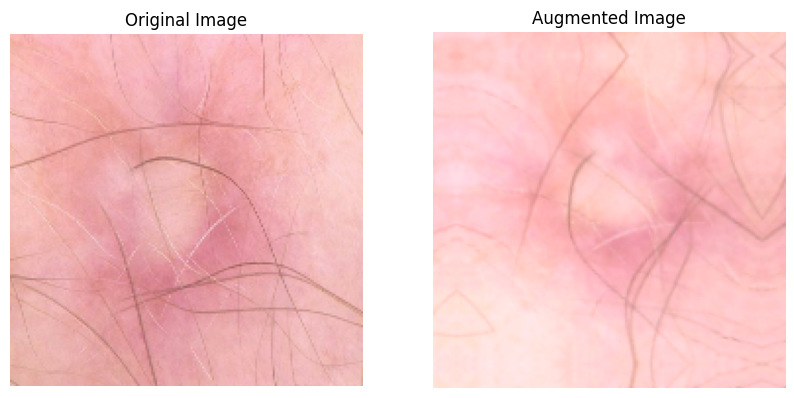

In [96]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
], name='data_augmentation')

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    img = images[0]

    # Display original image
    ax = plt.subplot(1, 2, 1)
    ax.set_title("Original Image")  # Fixed the title call
    plt.imshow(img.numpy().astype("uint8"))
    plt.axis("off")

    # Display augmented image
    augmented_image = data_augmentation(img)
    ax = plt.subplot(1, 2, 2)
    ax.set_title("Augmented Image")  # Fixed the title call
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.axis("off")

plt.show()



### Create the model, compile and train the model


In [97]:
def build_model(input_shape=(img_height, img_width, 3), num_classes=len(class_names)):
    # Create input layer
    inputs = Input(shape=input_shape)

    # Rescaling
    x = layers.Rescaling(1./255)(inputs)

    # Data augmentation
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.2)(x)
    x = layers.RandomContrast(0.2)(x)

    # First Convolutional Block
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Second Convolutional Block
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Third Convolutional Block
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Flatten and Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Create the model
model_2 = build_model()

### Compiling the model

In [98]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_2.summary()


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_14 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_8 (RandomFlip)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_8 (RandomRotation)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_8 (RandomZoom)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_8 (RandomContrast)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,152,105 (61.62 MB)

 Trainable params: 16,150,697 (61.61 MB)

 Non-trainable params: 1,408 (5.50 KB)

### Training the model

In [99]:


epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.2926 - loss: 2.2085 - val_accuracy: 0.1713 - val_loss: 8.0711
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 35s 124ms/step - accuracy: 0.4045 - loss: 1.6316 - val_accuracy: 0.3894 - val_loss: 2.1445
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 35s 124ms/step - accuracy: 0.4563 - loss: 1.4480 - val_accuracy: 0.4237 - val_loss: 1.5980
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - accuracy: 0.4715 - loss: 1.3985 - val_accuracy: 0.4553 - val_loss: 1.4616
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - accuracy: 0.5169 - loss: 1.2935 - val_accuracy: 0.2448 - val_loss: 4.9547
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - accuracy: 0.4724 - loss: 1.4013 - val_accuracy: 0.4744 - val_loss: 1.3958
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - accuracy: 0.5380 - loss: 1.2327 - val_accuracy: 0.2773 - val_loss: 2.4734
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - accuracy: 0.5726 - loss: 1

### Visualizing the results

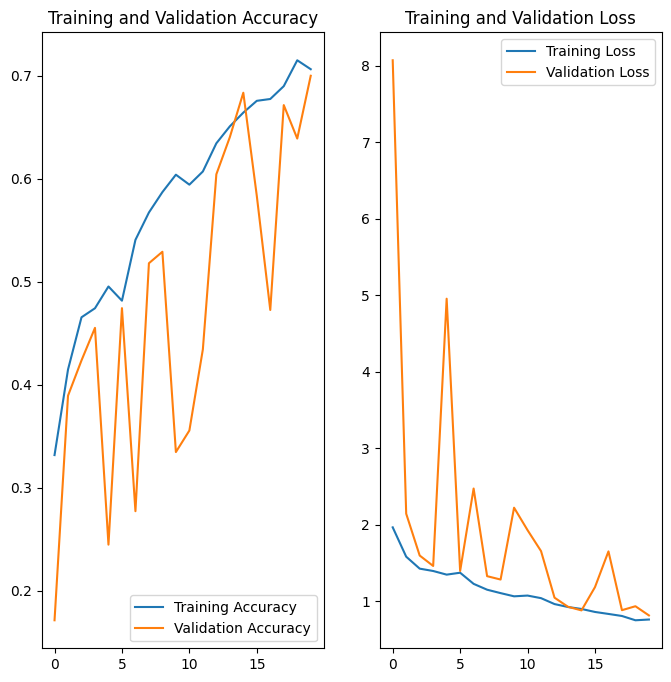

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### The training accuracy consistently increasing.

##### The validation accuracy fluctuates significantly, reaching a peak early but then declining, especially toward the final epochs. This suggests that the model may be overfitting to the training data after a certain point. Overfitting occurs when the model performs well on the training data but poorly on unseen validation data.

#### he large fluctuations in validation accuracy and the spikes in validation loss are typical signs of overfitting.

##### The training loss consistently decreases throughout the epochs, indicating that the model is optimizing its weights to fit the training data better.

##### The validation shows significant spikes, especially after epoch 10, suggesting potential overfitting. The model performs well on the training set but struggles on the validation set.

####  Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class Distribution in the Training Dataset:
actinic keratosis: 907
basal cell carcinoma: 1086
dermatofibroma: 870
melanoma: 1150
nevus: 1104
pigmented benign keratosis: 1163
seborrheic keratosis: 867
squamous cell carcinoma: 945
vascular lesion: 900


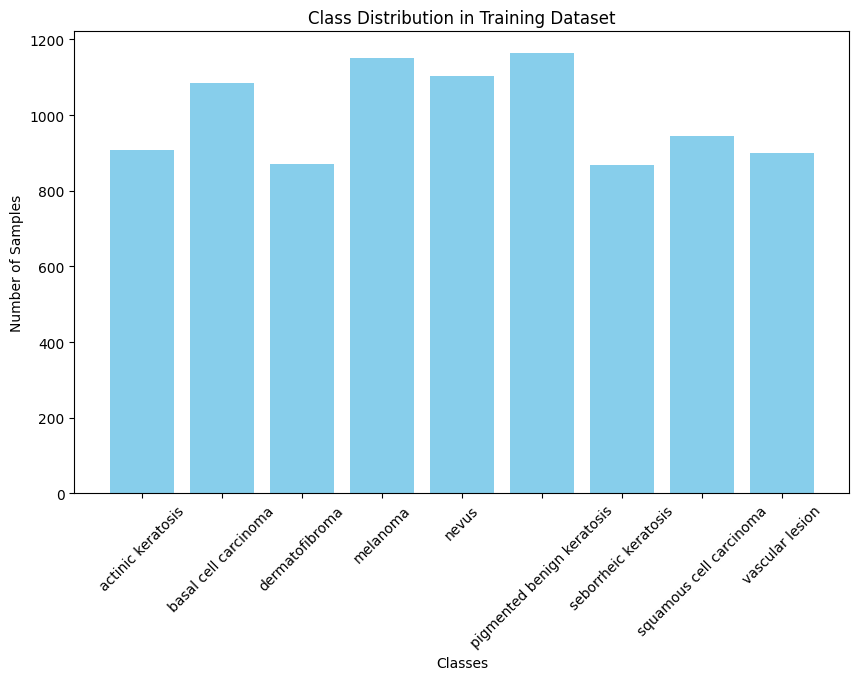

In [101]:
# Initialize a dictionary to keep track of class counts

class_counts = {class_name: 0 for class_name in class_names}


for images, labels in train_ds:
    unique, counts = np.unique(labels.numpy(), return_counts=True)
    for label, count in zip(unique, counts):
        class_counts[class_names[label]] += count

# Display the class distribution
print("Class Distribution in the Training Dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

#### There is a noticeable imbalance in the number of samples for different classes.Pigmented benign keratosis and nevus have the highest number of samples, around 350-360.Actinic keratosis, dermatofibroma, and seborrheic keratosis have the lowest number of samples, each with less than 150.

#### The melanoma class, which is the target condition for detection, has about 300 samples, which is a decent amount but still less than some other classes like nevus and pigmented benign keratosis.Classes like actinic keratosis, dermatofibroma, and seborrheic keratosis have relatively few samples. This underrepresentation may pose challenges for the model to learn features adequately for these classes and could lead to lower classification accuracy for them


#### Rectify Class Imbalance

In [102]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [103]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    # Use Path() to ensure correct path joining
    p = Augmentor.Pipeline(Path(path_to_training_dataset) / i)

    # Define your augmentation operations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Add 500 samples per class to avoid sparsity
    p.sample(500)

Initialised with 614 image(s) found.
Output directory set to /content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788BC8CAA9E0>: 100%|██████████| 500/500 [00:05<00:00, 90.87 Samples/s] 


Initialised with 876 image(s) found.
Output directory set to /content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788BC916A5F0>: 100%|██████████| 500/500 [00:04<00:00, 101.73 Samples/s]


Initialised with 595 image(s) found.
Output directory set to /content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x788BCA11E9B0>: 100%|██████████| 500/500 [00:04<00:00, 100.54 Samples/s]


Initialised with 938 image(s) found.
Output directory set to /content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x788BCA39D720>: 100%|██████████| 500/500 [00:15<00:00, 33.29 Samples/s]


Initialised with 857 image(s) found.
Output directory set to /content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x788CC2AD9E70>: 100%|██████████| 500/500 [00:12<00:00, 39.30 Samples/s]


Initialised with 962 image(s) found.
Output directory set to /content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788CC2AECBE0>: 100%|██████████| 500/500 [00:04<00:00, 101.05 Samples/s]


Initialised with 577 image(s) found.
Output directory set to /content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x788CC3BA2830>: 100%|██████████| 500/500 [00:07<00:00, 69.70 Samples/s]


Initialised with 681 image(s) found.
Output directory set to /content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x788BCA1AD060>: 100%|██████████| 500/500 [00:05<00:00, 94.88 Samples/s] 


Initialised with 639 image(s) found.
Output directory set to /content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788C70381DB0>: 100%|██████████| 500/500 [00:05<00:00, 93.77 Samples/s] 


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [104]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [105]:

# Get all image paths from the 'output' subdirectories of each class folder
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

path_list_new

['/content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010942.jpg_f75246b5-1808-48ea-ba07-cca1e164903c.jpg',
 '/content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011112.jpg_2b018276-941d-4580-b179-0d388c3dce57.jpg',
 '/content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_db8a1866-f866-4c97-bbba-ed5dc9493eac.jpg',
 '/content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011169.jpg_bfd47640-d3d9-442c-9f91-19973b3bf115.jpg',
 '/content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010977.jpg_04be1bef-2179-4c08-a4f0-310c3f6d8714.jpg',
 '/content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assign

In [106]:
# Get all image paths from the 'output' subdirectories of each class folder
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

# Extract the class names (parent directory names) from the image paths
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list]

set(lesion_list_new)

{'actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion'}

In [107]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

dataframe_dict_new

{'/content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010942.jpg_f75246b5-1808-48ea-ba07-cca1e164903c.jpg': 'seborrheic keratosis',
 '/content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011112.jpg_2b018276-941d-4580-b179-0d388c3dce57.jpg': 'seborrheic keratosis',
 '/content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011056.jpg_db8a1866-f866-4c97-bbba-ed5dc9493eac.jpg': 'seborrheic keratosis',
 '/content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011169.jpg_bfd47640-d3d9-442c-9f91-19973b3bf115.jpg': 'seborrheic keratosis',
 '/content/drive/My Drive/Learn/AI-ML/Upgrad/CNN/Assignment/Data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010977.jpg_04

In [108]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [109]:
df['Label'].value_counts()

,count
Label,
seborrheic keratosis,1000
basal cell carcinoma,1000
actinic keratosis,1000
pigmented benign keratosis,1000
melanoma,1000
nevus,1000
dermatofibroma,1000
vascular lesion,1000
squamous cell carcinoma,1000


#### **Todo**: Train the model on the data created using Augmentor

In [110]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [111]:
import shutil
# Path to your main training directory
data_dir_train_path = Path(data_dir_train)

# Loop through each class directory inside the training directory
for class_dir in data_dir_train.iterdir():
    if class_dir.is_dir():
        output_dir = class_dir / 'output'
        if output_dir.exists():
            for img_file in output_dir.glob('*.jpg'):
                dest_path = class_dir / img_file.name


                shutil.copy(str(img_file), str(dest_path))





#Copy the output images to main directory

In [112]:
#  Load the original dataset (from the main class directories)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 20239 files belonging to 9 classes.
Using 16192 files for training.


In [113]:
#Validation dataset
val_ds = image_dataset_from_directory(data_dir_train,
                                      validation_split=0.2,
                                      subset="validation",
                                      seed=123,
                                      image_size=(img_height, img_width),
                                      batch_size=batch_size)

Found 20239 files belonging to 9 classes.
Using 4047 files for validation.


In [114]:
#Build Model 3

# Create the model
model_3 = build_model()

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_2.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_14 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_8 (RandomFlip)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_8 (RandomRotation)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_8 (RandomZoom)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_8 (RandomContrast)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,152,105 (61.62 MB)

 Trainable params: 16,150,697 (61.61 MB)

 Non-trainable params: 1,408 (5.50 KB)

#### **Todo:**  Train your model

In [115]:
epochs = 30
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 79s 147ms/step - accuracy: 0.6743 - loss: 0.8638 - val_accuracy: 0.3536 - val_loss: 2.7739
Epoch 2/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 68s 133ms/step - accuracy: 0.6337 - loss: 0.9871 - val_accuracy: 0.7660 - val_loss: 0.6433
Epoch 3/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 68s 134ms/step - accuracy: 0.7094 - loss: 0.7636 - val_accuracy: 0.8003 - val_loss: 0.5205
Epoch 4/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 68s 134ms/step - accuracy: 0.7387 - loss: 0.6895 - val_accuracy: 0.7252 - val_loss: 0.7563
Epoch 5/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 68s 133ms/step - accuracy: 0.7457 - loss: 0.6800 - val_accuracy: 0.6778 - val_loss: 0.9335
Epoch 6/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 67s 133ms/step - accuracy: 0.7554 - loss: 0.6511 - val_accuracy: 0.8036 - val_loss: 0.5267
Epoch 7/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 68s 133ms/step - accuracy: 0.7772 - loss: 0.6162 - val_accuracy: 0.7685 - val_loss: 0.6192
Epoch 8/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 67s 133ms/step - accuracy: 0.7747 - loss: 0

#### Visualize the model results


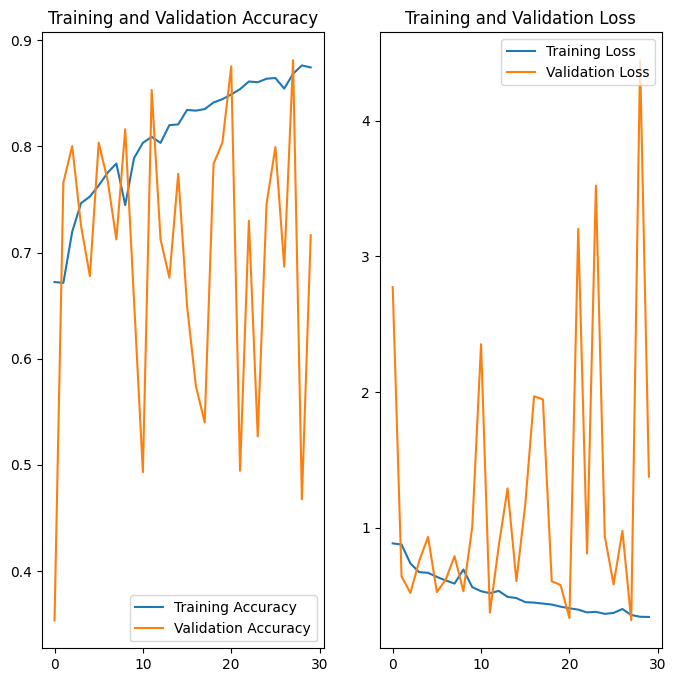

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#####  Training Accuracy increases steadily over time, stabilizing around 0.75 to 0.8, which indicates that the model is learning well from the training data

#### Validation Accuracy is quite volatile. It fluctuates significantly across epochs, peaking around 0.8 but also showing large dips, especially around epoch 20 and beyond. This volatility might suggest overfitting or instability in learning, but the valiadtion accuracy is in par with the training accuray

#### Training Loss gradually decreases, as expected, which shows that the model is minimizing the error during training. This is typical behavior of a model learning effectively.

#### Validation Loss, similar to the validation accuracy, is highly volatile. It spikes dramatically at certain epochs, which may indicate issues such as overfitting, or a lack of generalization to the validation data despite handling class imbalance
